# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

from datetime import datetime, timedelta, date
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K
from keras import layers
from keras.initializers import Zeros
from keras.callbacks import EarlyStopping
from keras.models import load_model

# Set random seed
np.random.seed(0)
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Set figure size for all matplotlib figures
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5

## Read The Data

In [ ]:
df = pd.read_excel('/content/DEXINUS.xls',
                   skiprows=10,
                   index_col=[0],
                   parse_dates=True)
df.head(10)

,DEXINUS
observation_date,
1973-01-02,8.02
1973-01-03,8.02
1973-01-04,8.00
1973-01-05,8.01
1973-01-08,8.00
1973-01-09,8.00
1973-01-10,8.00
1973-01-11,8.00
1973-01-12,8.00


In [ ]:
#Fill missing values using interpolation
df['DEXINUS'].interpolate(method='linear',
                          limit_direction='forward',
                          inplace=True)

In [ ]:
# df.isna().sum()

# Train test split

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df)
data1 = scaler.transform(df)
data1

array([[0.01189794],
       [0.01189794],
       [0.01161124],
       ...,
       [0.95957569],
       [0.95971904],
       [0.95971904]])

In [ ]:
len(data1)

12649

In [ ]:

train_size = int(12649-525)  #95% for training
print(train_size,len(data1),type(data1))

train = data1[:train_size]
test = data1[train_size:]

X_train = train[:-1]
y_train = train[1:]

X_test = test[:-1]
y_test = test[1:]
len(X_train),len(X_test), len(y_train), len(y_test)

12124 12649 <class 'numpy.ndarray'>


(12123, 524, 12123, 524)

In [ ]:
# pd.DataFrame(zip(X_train,y_train))
train[-3:],test[:5]

(array([[0.89521216],
        [0.89234518],
        [0.89449541]]), array([[0.890625  ],
        [0.88976491],
        [0.88861812],
        [0.88618119],
        [0.88489106]]))

# ANN

Import the Tensor and Keras functions for ANN

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout


def adj_r2_score(r2, n, k):
    return 1 - ((1 - r2) * ((n - 1) / (n - k - 1)))

In [ ]:
K.clear_session()

model = Sequential()
model.add(Dense(30, input_dim=1, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')],
              optimizer='adam')

early_stop = EarlyStopping(monitor='loss', patience=8, verbose=1)

history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=1,
                    verbose=1,
                    callbacks=[early_stop],
                    shuffle=False,
                    ) #workers=5

Epoch 1/100
12123/12123 [==============================] - 39s 2ms/step - loss: 5.0925e-06 - rmse: 0.0018
Epoch 2/100
12123/12123 [==============================] - 24s 2ms/step - loss: 0.0013 - rmse: 0.0124
Epoch 3/100
12123/12123 [==============================] - 24s 2ms/step - loss: 6.0291e-04 - rmse: 0.0111
Epoch 4/100
12123/12123 [==============================] - 24s 2ms/step - loss: 3.9199e-04 - rmse: 0.0102
Epoch 5/100
12123/12123 [==============================] - 23s 2ms/step - loss: 2.0696e-04 - rmse: 0.0093
Epoch 6/100
12123/12123 [==============================] - 23s 2ms/step - loss: 1.4578e-04 - rmse: 0.0087
Epoch 7/100
12123/12123 [==============================] - 23s 2ms/step - loss: 1.1240e-04 - rmse: 0.0082
Epoch 8/100
12123/12123 [==============================] - 23s 2ms/step - loss: 6.7282e-05 - rmse: 0.0077
Epoch 9/100
12123/12123 [==============================] - 23s 2ms/step - loss: 6.4823e-05 - rmse: 0.0074
Epoch 00009: early stopping


In [ ]:
y_train[:10]

array([[0.01189794],
       [0.01161124],
       [0.01175459],
       [0.01161124],
       [0.01161124],
       [0.01161124],
       [0.01161124],
       [0.01161124],
       [0.01161124],
       [0.01175459]])

# Check the performance metrics

In [ ]:
# import sklearn.metrics as metrics
from sklearn.metrics import r2_score

def MAPE(y,yhat):
    return np.mean(np.abs((y - yhat)/y)*100)

y_pred_test = scaler.inverse_transform(model.predict(X_test))
y_train_pred = scaler.inverse_transform(model.predict(X_train))

train_mse = metrics.mean_squared_error(scaler.inverse_transform(y_train), y_train_pred)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(scaler.inverse_transform(y_test), y_pred_test)
rmse_test = np.sqrt(test_mse)

print(' \033[7m On Train Data \033[0m\n')
print("The  R2 score on the Train set is :\t{:0.3f}".format(
    r2_score(scaler.inverse_transform(y_train), y_train_pred)))
print("The  MAE on the Train set is      :\t{:0.3f}".format(
    metrics.mean_absolute_error(scaler.inverse_transform(y_train), y_train_pred)))

print("The  RMSE on the Train set is     :\t{:0.3f}".format(rmse_train))
r2_train = r2_score(scaler.inverse_transform(y_train), y_train_pred)

print("The  MAPE on the Train Set is     :\t{:.3f}%"\
      .format(MAPE(scaler.inverse_transform(y_train),y_train_pred)))

print('\n\n \033[7m On Test Data \033[0m\n')

print("The  R2 score on the Test set is  :\t{:0.3f}".format(
    r2_score(scaler.inverse_transform(y_test), y_pred_test)))
r2_test = r2_score(scaler.inverse_transform(y_test), y_pred_test)

print("The  MAE on the Test set is       :\t{:0.3f}".format(
    metrics.mean_absolute_error(scaler.inverse_transform(y_test), y_pred_test)))
print("The  RMSE on the Test set is      :\t{:0.3f}".format(rmse_test))

print("The  MAPE on the Test Set is     :\t{:.3f}%".\
      format(MAPE(scaler.inverse_transform(y_test),y_pred_test)))

  On Train Data 

The  R2 score on the Train set is :	0.930
The  MAE on the Train set is      :	4.627
The  RMSE on the Train set is     :	5.288
The  MAPE on the Train Set is     :	34.178%


  On Test Data 

The  R2 score on the Test set is  :	0.901
The  MAE on the Test set is       :	0.506
The  RMSE on the Test set is      :	0.591
The  MAPE on the Test Set is     :	0.685%


### Checking the MAPE Manually

In [ ]:
Temp = pd.concat([
    pd.DataFrame(scaler.inverse_transform(y_test), columns=['yTrue']),
    pd.DataFrame(y_pred_test, columns=['yHat'])
    ],
                 axis=1)

print(np.mean(np.abs((Temp['yHat']-Temp['yTrue'])/Temp['yTrue'])))

0.006850705798801523


In [ ]:
Temp.tail(7)

,yTrue,yHat
517,74.16,72.796135
518,74.14,73.540962
519,74.18,73.523438
520,74.37,73.558495
521,74.13,73.724983
522,74.14,73.514679
523,74.14,73.523438


### Plotting the prediction vs actuals on Test data

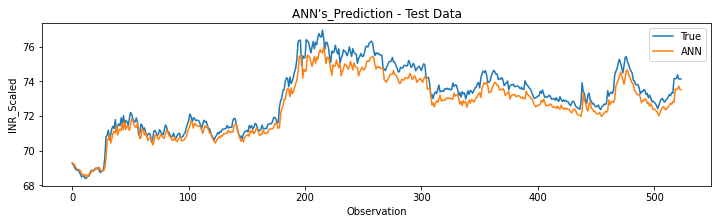

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(scaler.inverse_transform(y_test), label='True')
plt.plot(y_pred_test, label='ANN')
# plt.plot(rate_data_log[:10118].index,y_train, label='True')
# plt.plot(rate_data_log[:10118].index,y_train_pred, label='ANN')
plt.title("ANN's_Prediction - Test Data")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

### Plotting prediciton vs Actuals on Train Data

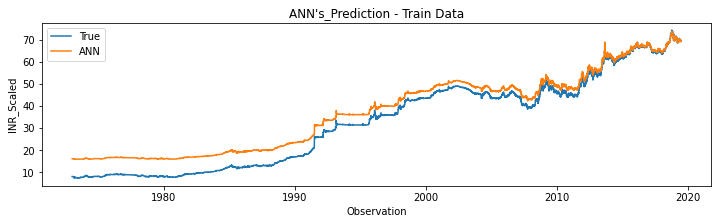

In [ ]:
plt.figure(figsize=(12, 3))
# plt.plot(y_test, label='True')
# plt.plot(y_pred_test, label='ANN')
plt.plot(df[:12123].index, scaler.inverse_transform(y_train), label='True')
plt.plot(df[:12123].index, y_train_pred, label='ANN')
plt.title("ANN's_Prediction - Train Data")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

# LSTM

Long Term Short Memory (LSTM) networks are another variant of RNNs. They are capable of retaining long term dependencies among the sequence of events or data points.

In [ ]:
# list(data1.reshape(12649))[:10]

# Reshape the data for LSTM model

In [ ]:
data2 = list(data1.reshape(12649))
train_size = int(12649-525)#12649-525
print(train_size,len(data2),type(data2), sep = ' -  ')

train1 = data2[:train_size]
test1 = data2[train_size:]

train_list = [x for x in train1]
predictions = []
len(train1),len(test1)

12124 -  12649 -  <class 'list'>


(12124, 525)

In [ ]:
## Define a custom fuction to create a lagged array with custom lag size for LSTM model

def gen_XY(t_list, size):
    '''
    Generates an autoregressive lagged array.
    
    Parameters
    ----------
    1. t_list: (list) Data to generate an autoregressive array out of.
    2. size: (int) Number of lagged values to consider.
    
    Returns
    ----------
    1. X: (np.ndarray) Autoregressive feature array.
    2. Y.T: (np.ndarray) Column array with values of response variable.
    
    '''
    X = np.zeros([1, size])
    Y = []
    temp_list = []
    for i in range(len(t_list) - size):
        add_list = t_list[i:i + size]
        target = t_list[i + size]
        X = np.append(X, np.array([add_list]), axis=0)
        Y.append(target)

    X = np.delete(X, 0, axis=0)
    Y = np.array(Y)

    return X, Y.T

In [ ]:
# type(train1),len(train1)

In [ ]:
X_train, y_train = gen_XY(train1, 1)
X_test, y_test = gen_XY(test1, 1)

In [ ]:
print(y_train.shape,y_test.shape,type(y_train))
print(y_train[:5])
print(y_train.reshape(12123,-1))

(12123,) (524,) <class 'numpy.ndarray'>
[0.01189794 0.01161124 0.01175459 0.01161124 0.01161124]
[[0.01189794]
 [0.01161124]
 [0.01175459]
 ...
 [0.89521216]
 [0.89234518]
 [0.89449541]]


In [ ]:
X_train.shape,X_train.shape

((12123, 1), (12123, 1))

In [ ]:
#LSTM Preprocessing
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
print(X_tr_t.shape,X_tst_t.shape)
X_tr_t[:5]

(12123, 1, 1) (524, 1, 1)


array([[[0.01189794]],

       [[0.01189794]],

       [[0.01161124]],

       [[0.01175459]],

       [[0.01161124]]])

## Model Inititalisation and Training

In [ ]:
from keras.layers import LSTM

K.clear_session()
model_lstm = Sequential()
model_lstm.add(
    LSTM(50,
         input_shape=(600,X_train.shape[1]),
         activation='relu',
#          kernel_initializer='lecun_uniform',
         return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# (50*1+1)*50*4

#### Observation:As we can see from the above code, we have used 50 neurons in the LSTM cell with activation function relu, kernel initializer lecun_uniform, and return sequence False.

In [ ]:
model_lstm.compile(
    loss=tf.keras.metrics.mean_squared_error,
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')],
    optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t,
                                    y_train,
                                    epochs=100,
                                    batch_size=1,
                                    verbose=1,
                                    shuffle=False,
                                    callbacks=[early_stop])

Epoch 1/100
12123/12123 [==============================] - 47s 3ms/step - loss: 5.9739e-06 - rmse: 0.0019
Epoch 2/100
12123/12123 [==============================] - 38s 3ms/step - loss: 0.0022 - rmse: 0.0161
Epoch 3/100
12123/12123 [==============================] - 38s 3ms/step - loss: 0.0011 - rmse: 0.0145
Epoch 4/100
12123/12123 [==============================] - 38s 3ms/step - loss: 6.0002e-04 - rmse: 0.0131
Epoch 5/100
12123/12123 [==============================] - 38s 3ms/step - loss: 3.8206e-04 - rmse: 0.0120
Epoch 6/100
12123/12123 [==============================] - 37s 3ms/step - loss: 2.4829e-04 - rmse: 0.0112
Epoch 00006: early stopping


## Checking the Accuracy 

In [ ]:
y_pred_test_lstm = scaler.inverse_transform(model_lstm.predict(X_tst_t))
y_train_pred_lstm = scaler.inverse_transform(model_lstm.predict(X_tr_t))
iy_train = scaler.inverse_transform(y_train.reshape(12123,-1))
iy_test = scaler.inverse_transform(y_test.reshape(524,-1))

train_mse = metrics.mean_squared_error(iy_train, y_train_pred_lstm)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(iy_test, y_pred_test_lstm)
rmse_test = np.sqrt(test_mse)
print('The Scores on Train Data')
print('-----------------------')
print("The R2 score on the Train set is           :\t{:0.3f}".format(
    r2_score(iy_train, y_train_pred_lstm)))
print("The  MAE on the Train set is               :\t{:0.3f}".format(
    metrics.mean_absolute_error(iy_train, y_train_pred_lstm)))

print("The  RMSE on the Train set is              :\t{:0.3f}".format(rmse_train))
r2_train = r2_score(iy_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is  :\t{:0.3f}".format(
    adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print('The MAPE on Train set is                   :\t{:.3f} %\n'.format(MAPE(iy_train,y_train_pred_lstm)))

print('The Scores on Test Data')
print('----------------------')
print("The R2 score on the Test set is            :\t{:0.3f}".format(
    r2_score(iy_test, y_pred_test_lstm)))
r2_test = r2_score(iy_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is   :\t{:0.3f}".format(
    adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is                :\t{:0.3f}".format(
    metrics.mean_absolute_error(iy_test, y_pred_test_lstm)))
print("The  RMSE on the Test set is               :\t{:0.3f}".format(rmse_test))
print('The MAPE on the Test Set is                :\t{:.3f} %'.format(MAPE(iy_test,y_pred_test_lstm)))

The Scores on Train Data
-----------------------
The R2 score on the Train set is           :	0.866
The  MAE on the Train set is               :	5.841
The  RMSE on the Train set is              :	7.283
The Adjusted R2 score on the Train set is  :	0.866
The MAPE on Train set is                   :	47.954 %

The Scores on Test Data
----------------------
The R2 score on the Test set is            :	0.977
The Adjusted R2 score on the Test set is   :	0.977
The  MAE on the Test set is                :	0.209
The  RMSE on the Test set is               :	0.287
The MAPE on the Test Set is                :	0.285 %


## Plotting the prediction vs Actual on Test Data

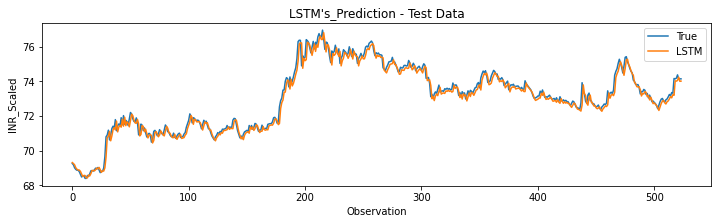

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(iy_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's_Prediction - Test Data")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

## Plotting Prediction vs Actuals on Train Data

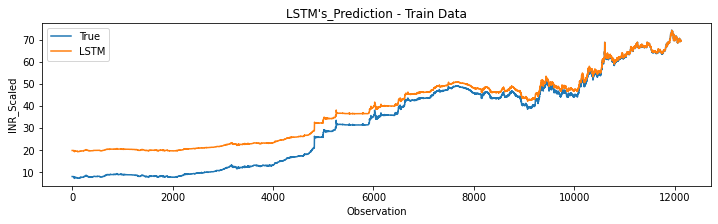

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(iy_train, label='True')
plt.plot(y_train_pred_lstm, label='LSTM')
plt.title("LSTM's_Prediction - Train Data")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

As we can see from above plot, LSTM performs well for test data than ANN. IT can be ovserved that on Train data LSTM tries to keep the most recent information for prediction and predicts the nearterm better than the past. 

# GRU

Gated Recurrent Unit (GRU) and LSTM both have the characterstics to retain the long term dependency of past sequence of events. The major difference between the two is LSTMs control the exposure of memory content (cell state) while GRUs expose the entire cell state to other units in the network.

We can use the same data shape of LSTM for GRU hence we can directly prodeceed to model building.

In [ ]:
#GRU
from keras.layers import GRU

K.clear_session()
model_gru = Sequential()
model_gru.add(
    GRU(7,
        input_shape=(100, X_train.shape[1]),
        activation='linear',
        kernel_initializer='lecun_uniform',
        return_sequences=False))
model_gru.add(Dense(1))
model_gru.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 7)                 210       
_________________________________________________________________
dense (Dense)                (None, 1)                 8         
Total params: 218
Trainable params: 218
Non-trainable params: 0
_________________________________________________________________


#### We have build a light weight GRU model having only 7 neurons in hidden layer due to which total model parameters are only 218

In [ ]:
model_gru.compile(loss=tf.keras.metrics.mean_squared_error,
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')],
                  optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_gru = model_gru.fit(X_tr_t,
                                  y_train,
                                  epochs=100,
                                  batch_size=1,
                                  verbose=1,
                                  shuffle=False,
                                  callbacks=[early_stop])

Epoch 1/100
12123/12123 [==============================] - 42s 3ms/step - loss: 7.8697e-06 - rmse: 0.0023
Epoch 2/100
12123/12123 [==============================] - 38s 3ms/step - loss: 0.0022 - rmse: 0.0160
Epoch 3/100
12123/12123 [==============================] - 39s 3ms/step - loss: 7.2309e-04 - rmse: 0.0136
Epoch 4/100
12123/12123 [==============================] - 38s 3ms/step - loss: 3.1006e-04 - rmse: 0.0120
Epoch 5/100
12123/12123 [==============================] - 39s 3ms/step - loss: 1.7026e-04 - rmse: 0.0108
Epoch 6/100
12123/12123 [==============================] - 39s 3ms/step - loss: 1.0628e-04 - rmse: 0.0099
Epoch 00006: early stopping


## Check the accuracy on both train and test

In [ ]:
y_pred_test_gru = scaler.inverse_transform(model_gru.predict(X_tst_t))
y_train_pred_gru = scaler.inverse_transform(model_gru.predict(X_tr_t))

train_mse = metrics.mean_squared_error(iy_train, y_train_pred_gru)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(iy_test, y_pred_test_gru)
rmse_test = np.sqrt(test_mse)

print('The Score on Train Data')
print('----------------------')

print("The R2 score on the Train set is            :\t{:0.3f}".format(
    r2_score(iy_train, y_train_pred_gru)))
print("The  MAE on the Train set is                :\t{:0.3f}".format(
    metrics.mean_absolute_error(iy_train, y_train_pred_gru)))

print("The  RMSE on the Train set is               :\t{:0.3f}".format(rmse_train))
r2_train = r2_score(iy_train, y_train_pred_gru)
print("The Adjusted R2 score on the Train set is   :\t{:0.3f}".format(
    adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print('The MAPE on the Train set is                :\t{:.3f} %\n'.format(
    MAPE(iy_train,y_train_pred_gru)))
print('The Score on Test Data')
print('---------------------')
print("The R2 score on the Test set is             :\t{:0.3f}".format(
    r2_score(iy_test, y_pred_test_gru)))
r2_test = r2_score(iy_test, y_pred_test_gru)
print("The Adjusted R2 score on the Test set is    :\t{:0.3f}".format(
    adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is                 :\t{:0.3f}".format(
    metrics.mean_absolute_error(iy_test, y_pred_test_gru)))
print("The  RMSE on the Test set is                :\t{:0.3f}".format(rmse_test))
print('The MAPE on Test set is                     :\t{:.3f} %'.format(
    MAPE(iy_test,y_pred_test_gru)))

The Score on Train Data
----------------------
The R2 score on the Train set is            :	0.845
The  MAE on the Train set is                :	7.435
The  RMSE on the Train set is               :	7.853
The Adjusted R2 score on the Train set is   :	0.845
The MAPE on the Train set is                :	45.447 %

The Score on Test Data
---------------------
The R2 score on the Test set is             :	0.426
The Adjusted R2 score on the Test set is    :	0.425
The  MAE on the Test set is                 :	1.262
The  RMSE on the Test set is                :	1.426
The MAPE on Test set is                     :	1.707 %


## plotting the prediction vs actuals on Test Data

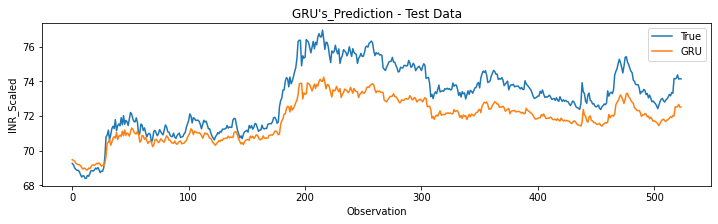

In [ ]:
#GRU Prediction PLot
plt.figure(figsize=(12, 3))
plt.plot(iy_test, label='True')
plt.plot(y_pred_test_gru, label='GRU')
plt.title("GRU's_Prediction - Test Data")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

## Plotting the Prediction vs Actuals on the Train Data

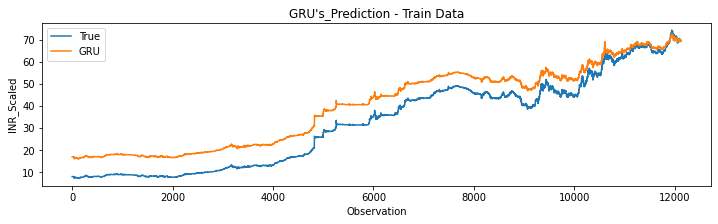

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(iy_train, label='True')
plt.plot(y_train_pred_gru, label='GRU')
plt.title("GRU's_Prediction - Train Data")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')

plt.legend()
plt.show()

In [2]:
print('Comparing all the Neural Network Models')
print('---------------------------------------')

print('''"The MAPE on ANN model is     :	0.784%"
"The MAPE on GRU model is     :	0.335 %"
"The MAPE on LSTM model is    :	0.279 %"''')

Comparing all the Neural Network Models
---------------------------------------
"The MAPE on ANN model is     :	0.784%"
"The MAPE on GRU model is     :	0.335 %"
"The MAPE on LSTM model is    :	0.279 %"


# Building the final model with full data -> see another notebook